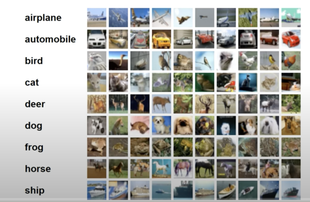

# download CFAR10 data base here:

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import os
import pickle
import warnings
import time
import tarfile


# Cifar folder names
CIFAR10_FOLDER = 'cifar-10-batches-py'
CIFAR100_FOLDER = 'cifar-100-python'

CIFAR10_URL_PYTHON = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
CIFAR10_MD5 = 'c58f30108f718f92721af3b95e74349a'
CIFAR100_URL_PYTHON = 'https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz'
CIFAR100_MD5 = 'eb9058c3a382ffc7106e4002c42a8d85'


def _download_cifar(data_dir, cifar10=True):
    os.makedirs(data_dir, exist_ok=True)

    if cifar10:
        filename = CIFAR10_URL_PYTHON.split('/')[-1]
        data_cifar10 = os.path.join(data_dir, filename)

        # Don't re-download if it already exists
        if not os.path.exists(data_cifar10):
            need = True
        elif md5(data_cifar10) != CIFAR10_MD5:
            need = True
            print('File found but md5 checksum different. Redownloading.')
        else:
            print('Tar File found in dest_dir. Not Downloading again')
            need = False

        if need:
            print("Downloading Python CIFAR10 Data.")
            download(CIFAR10_URL_PYTHON, data_dir)

        # Extract and prepare CIFAR10 DATA
        print("Extracting Python CIFAR10 data.")
        tarfile.open(data_cifar10, 'r:gz').extractall(data_dir)
        print('Files extracted')

    else:
        # Download CIFAR100 DATA PYTHON
        filename = CIFAR100_URL_PYTHON.split('/')[-1]
        data_cifar100 = os.path.join(data_dir, filename)

        # Don't re-download if it already exists
        if not os.path.exists(data_cifar100):
            need = True
        elif md5(data_cifar100) != CIFAR100_MD5:
            need = True
            print('File found but md5 checksum different. Redownloading.')
        else:
            print('Tar File found in dest_dir. Not Downloading again.')
            need = False

        if need:
            print("Downloading Python CIFAR100 Data.")
            download(CIFAR100_URL_PYTHON, data_dir)

        # Extract and prepare CIFAR100
        print("Extracting Python CIFAR100 data.")
        tarfile.open(data_cifar100, 'r:gz').extractall(data_dir)
        print('Files extracted')

def load_cifar_data(data_dir, cifar10=True, val_size=2000, one_hot=True,download=False):
    """Load cifar10 or cifar100 data

    Parameters
    ----------
    data_dir : str
        Path to the folder with the cifar files in them. These should be the
        python files as downloaded from `cs.toronto`__

        __ https://www.cs.toronto.edu/~kriz/cifar.html
    cifar10 : bool
        True if cifar10, false if cifar100
    val_size : int
        Size of the validation set.
    one_hot : bool
        True to return one hot labels
    download : bool
        True if you don't have the data and want it to be downloaded for you.

    Returns
    -------
    trainx : ndarray
        Array containing training images. There will be 50000 - `val_size`
        images in this.
    trainy : ndarray
        Array containing training labels. These will be one hot if the one_hot
        parameter was true, otherwise the standard one of k.
    testx : ndarray
        Array containing test images. There will be 10000 test images in this.
    testy : ndarray
        Test labels
    valx: ndarray
        Array containing validation images. Will be None if val_size was 0.
    valy: ndarray
        Array containing validation labels. Will be None if val_size was 0.
    """
    # Download the data if requested
    if download:
        _download_cifar(data_dir, cifar10)

    # Set up the properties for each dataset
    if cifar10:
        if CIFAR10_FOLDER in os.listdir(data_dir) and \
           'data_batch_1' not in os.listdir(data_dir):
            # move the data directory down one
            data_dir = os.path.join(data_dir, CIFAR10_FOLDER)
        train_files = ['data_batch_'+str(x) for x in range(1,6)]
        train_files = [os.path.join(data_dir, f) for f in train_files]
        test_files = ['test_batch']
        test_files = [os.path.join(data_dir, f) for f in test_files]
        num_classes = 10
        label_func = lambda x: np.array(x['labels'], dtype='int32')
    else:
        if CIFAR100_FOLDER in os.listdir(data_dir) and \
           'train' not in os.listdir(data_dir):
            # move the data directory down one
            data_dir = os.path.join(data_dir, CIFAR100_FOLDER)
        train_files = ['train']
        train_files = [os.path.join(data_dir, f) for f in train_files]
        test_files = ['test']
        test_files = [os.path.join(data_dir, f) for f in test_files]
        num_classes = 100
        label_func = lambda x: np.array(x['fine_labels'], dtype='int32')

    # Load the data into memory
    def load_files(filenames):
        data = np.array([])
        labels = np.array([])
        for name in filenames:
            with open(name, 'rb') as f:
                mydict = pickle.load(f, encoding='latin1')

            # The labels have different names in the two datasets.
            newlabels = label_func(mydict)
            if data.size:
                data = np.vstack([data, mydict['data']])
                labels = np.hstack([labels, newlabels])
            else:
                data = mydict['data']
                labels = newlabels
        data = np.reshape(data, [-1, 3, 32, 32], order='C')
        data = np.transpose(data, [0, 2, 3, 1])
        if one_hot:
            labels = utils.convert_to_one_hot(labels, num_classes=num_classes)
        return data, labels

    train_data, train_labels = load_files(train_files)
    test_data, test_labels = load_files(test_files)
    if val_size > 0:
        train_data, val_data = np.split(train_data,
                                        [train_data.shape[0]-val_size])
        train_labels, val_labels = np.split(train_labels,
                                            [train_labels.shape[0]-val_size])
    else:
        val_data = None
        val_labels = None

    return train_data, train_labels, test_data, test_labels, val_data, \
        val_labels

def get_cifar_queues(data_dir, cifar10=True, val_size=2000, transform=None,
                     maxsize=10000, num_threads=(2,2,2),
                     max_epochs=float('inf'), get_queues=(True, True, True),
                     one_hot=True, download=False, _rand_data=False):
    """ Get Image queues for CIFAR

    CIFAR10/100 are both small datasets. This function loads them both into
    memory and creates several :py:class:`~dataset_loading.core.ImgQueue`
    instances to feed the training, testing and validation data through to the
    main function. Preprocessing can be done by providing a callable to the
    transform parameter. Note that by default, the CIFAR images returned will be
    of shape [32, 32, 3] but this of course can be changed by the transform
    function.

    Parameters
    ----------
    data_dir : str
        Path to the folder containing the cifar data. For cifar10, this should
        be the path to the folder called 'cifar-10-batches-py'. For
        cifar100, this should be the path to the folder 'cifar-100-python'.
    cifar10 : bool
        True if we are using cifar10.
    val_size : int
        How big you want the validation set to be. Will be taken from the end of
        the train data.
    transform : None or callable or tuple of callables
        Callable function that accepts a numpy array representing **one** image,
        and transforms it/preprocesses it. E.g. you may want to remove the mean
        and divide by standard deviation before putting into the queue. If tuple
        of callables, needs to be of length 3 and should be in the order
        (train_transform, test_transform, val_transform). Setting it to None
        means no processing will be done before putting into the image queue.
    maxsize : int or tuple of 3 ints
        How big the image queues will be. Increase this if your main program is
        chewing through the data quickly, but increasing it will also mean more
        memory is taken up. If tuple of ints, needs to be length 3 and of the
        form (train_qsize, test_qsize, val_qsize).
    num_threads : int or tuple of 3 ints
        How many threads to use for the train, test and validation threads (if
        tuple, needs to be of length 3 and in that order).
    max_epochs : int
        How many epochs to run before returning FileQueueDepleted exceptions
    get_queues : tuple of 3 bools
        In case you only want to have training data, or training and validation,
        or any subset of the three queues, you can mask the individual queues by
        putting a False in its position in this tuple of 3 bools.
    one_hot : bool
        True if you want the labels pushed into the queue to be a one-hot
        vector. If false, will push in a one-of-k representation.
    download : bool
        True if you want the dataset to be downloaded for you. It will be
        downloaded into the data_dir provided in this case.

    Returns
    -------
    train_queue : :py:class:`~dataset_loading.core.ImgQueue` instance or None
        Queue with the training data in it. None if get_queues[0] == False
    test_queue : :py:class:`~dataset_loading.core.ImgQueue` instance or None
        Queue with the test data in it. None if get_queues[1] == False
    val_queue : :py:class:`~dataset_loading.core.ImgQueue` instance or None
        Queue with the validation data in it. Will be None if the val_size
        parameter was 0 or get_queues[2] == False

    Notes
    -----
    If the max_epochs paramter is set to a finite amount, then when the queues
    run out of data, they will raise a dataset_loading.FileQueueDepleted
    exception.
    """
    # Process the inputs that can take multiple forms.
    if transform is None:
        train_xfm = None
        test_xfm = None
        val_xfm = None
    else:
        if type(transform) is tuple or type(transform) is list:
            assert len(transform) == 3
            train_xfm, test_xfm, val_xfm = transform
        else:
            train_xfm = transform
            test_xfm = transform
            val_xfm = transform

    if type(maxsize) is tuple or type(maxsize) is list:
        assert len(maxsize) == 3
        train_qsize, test_qsize, val_qsize = maxsize
    else:
        train_qsize = maxsize
        test_qsize = maxsize
        val_qsize = maxsize

    if type(num_threads) is tuple or type(num_threads) is list:
        assert len(num_threads) == 3
        train_threads, test_threads, val_threads = num_threads
    else:
        train_threads = num_threads
        test_threads = num_threads
        val_threads = num_threads

    # Check the validation size parameter
    if not get_queues[2]:
        if val_size > 0:
            warnings.warn(
                'Validation size was non-zero but the validation ' +
                'queue was not requested. Overriding validation size ' +
                'parameter and not splitting the train set.')
        val_size = 0

    # Load the data into memory
    if not _rand_data:
        tr_data, tr_labels, te_data, te_labels, val_data, val_labels = \
            load_cifar_data(data_dir, cifar10, val_size, one_hot)
    else:
        # Randomly generate some image like data
        tr_data = np.random.randint(255, size=(10000, 32, 32, 3))
        tr_labels = np.random.randint(10, size=(10000,))
        te_data = np.random.randint(255, size=(1000, 32, 32, 3))
        te_labels = np.random.randint(10, size=(1000,))
        val_data = np.random.randint(255, size=(1000, 32, 32, 3))
        val_labels = np.random.randint(10, size=(1000,))
        # convert to one hot
        tr_labels = utils.convert_to_one_hot(tr_labels)
        te_labels = utils.convert_to_one_hot(te_labels)
        val_labels = utils.convert_to_one_hot(val_labels)

    # Create the 3 queues
    train_queue = None
    test_queue = None
    val_queue = None
    if get_queues[0]:
        train_queue = core.ImgQueue(maxsize=train_qsize,
                                    name='CIFAR Train Queue')
        train_queue.take_dataset(tr_data, tr_labels, True, train_threads,
                                 train_xfm, max_epochs)
    if get_queues[1]:
        test_queue = core.ImgQueue(maxsize=test_qsize,
                                   name='CIFAR Test Queue')
        test_queue.take_dataset(te_data, te_labels, True, test_threads,
                                test_xfm)
    if get_queues[2] and (val_data is not None) and val_data.size > 0:
        val_queue = core.ImgQueue(maxsize=val_qsize,
                                  name='CIFAR Val Queue')
        val_queue.take_dataset(val_data, val_labels, True, val_threads,
                               val_xfm)

    # allow for the filling of the queues with some samples
    time.sleep(0.5)
    return train_queue, test_queue, val_queue


In [2]:
X_train, y_train, X_test, y_test = cifar10(path=None)

NameError: name 'cifar10' is not defined

In [ ]:
print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

In [ ]:
print(y_train[:10])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt  # a package to draw

# Operation on numpy array

In [ ]:
x = np.array([[1,2], [3,4]], dtype=np.float64)
y = np.array([[5,6],[7,8]], dtype = np.float64)
print(x)
print()
print(y)

In [ ]:
#Elementwise
print(x+y)
print()
print(np.add(x, y))

In [ ]:
print(x-y)
print()
print(np.subtract(x,y))


# Matrix multiplication in numpy
Note that unlike MATLAB, * is elementwise multiplication, not matrix multiplication.

We instead use the dot function to compute:

inner products of vectors,
multiply a vector by a matrix, and
multiply matrices.
dot is available both as a function in the numpy module and as an instance method of array objects:

In [ ]:
v = np.array([9,10])
w = np.array([11, 12])
print(v,'\n', w)

In [ ]:
#product of vectors
print(v.dot(w))
print(np.dot(v,w))

In [ ]:
#Matrix / vector product
print(x.dot(w))

## Transpose:

In [ ]:
print(x)
print()
print(x.T)

# Other usefull functions:

In [ ]:
x = np.array([[1,2], [3,4]])
print(x)

In [ ]:
for func in [x.min, x.max, x.var, x.std]:
    print (func.__name__ , '=', func())

# Broadcasting:

#### first rule:

In [ ]:
x = np.arange(5).reshape(1,1,5)
print(x)

In [ ]:
y = np.arange(5)
print(y)

In [ ]:
print(x+y)


#### second rule:

In [ ]:
x = np.arange(6).reshape(2,3)
print(x)

In [ ]:
y = np.arange(2).reshape(2,1)
print(y)

In [ ]:
print(x+y)

#### Combining rules 1 & 2:

In [ ]:
x = np.arange(6).reshape(2,3)
print(x)

In [ ]:
y = np.arange(3)
print(y)

In [ ]:
print(x+y)

# conditional operaters:

In [ ]:
x = np.array([9, 69, 87, 45])
print(x>45)

In [ ]:
# Boolean indexing
print(x[x>45])

## Stacking arrays

##### vstach, hstack

In [ ]:
A = np.full((6,5), 100)
print(A)

In [ ]:
B = np.full((6,5), 999)
print(B)

In [ ]:
C = np.vstack((A,B))
print(C)

In [ ]:
D = np.hstack((A,B))
print(D)

# Transposing arrays
The `transpose` method creates a new view on an `ndarray`'s data, with axes permuted in the given order.

For example, let's create a 3D array:

In [ ]:
A = np.arange(24).reshape(4,2,3)
print(A)

In [ ]:
B = A.transpose((1,2,0))
print(B)

## Saving and Loading

In [ ]:
A = np.random.rand(5, 4)
print(A)

In [ ]:
# np.save('myArray', A)
# np.load('myArray.py')

### Text format

In [ ]:
# np.savetxt('my_array.csv', A)
# B = np.loadtxt('my_array.csv')

## Matplotlib

In [ ]:
import matplotlib.pyplot as plt

By running this special iPython command, we will be displaying plots inline:

In [ ]:
%matplotlib inline

In [ ]:
# Compute the x and y coordinates for points on a sine curve
x = np.arange(0, 3 * np.pi, 0.1)
y1 = np.sin(x)

# Plot the points using matplotlib
plt.plot(x, y1);